In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import set_config
set_config(working_memory=1024)

In [2]:
data = pd.read_csv('tlacuachitos_vip_customers_data.csv')
data.head()

,CustomerID,Age,Income,Tenure,Education,Industry,Geographic Location,Churn_Risk,Cohort
0,1,56,52752.677346,3,Master,Technology,Europe,1,2023-08-31
1,2,69,55297.364348,6,Bachelor,Technology,South America,0,2021-08-31
2,3,46,57978.753383,3,Bachelor,Finance,Europe,1,2019-05-31
3,4,32,60445.266900,3,High School,Education,South America,1,2021-02-28
4,5,60,57741.870929,5,Bachelor,Entertainment,Asia,0,2018-10-31


In [3]:
df_transactions = pd.read_csv('tlacuachitos_vip_transactions.csv')
df_transactions.head()

,CustomerID,TransactionDate,TransactionAmount
0,1,2023-10-31,518.444092
1,1,2024-07-31,353.796197
2,1,2024-01-31,38.206591
3,1,2024-06-30,724.929423
4,2,2022-02-28,145.616000


In [4]:
# Convertir variables categóricas en variables dummies
categorical_features = ['Education','Industry','Geographic Location']
data_encoded = pd.get_dummies(data, columns=categorical_features, drop_first=True)

# Preparar los datos seleccionando características relevantes y normalizándolos
features = ['Age', 'Income'] + list(data_encoded.columns[6:])  # Incluir características categóricas codificadas
x = data_encoded.loc[:, features].values
x = StandardScaler().fit_transform(x)  # Normalización de las características

In [5]:
# Dar más peso a ciertas variables para la agrupación
x_df = pd.DataFrame(x)
x_df[3] = x_df[3] * 1.2
x_df

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.824019,0.121621,-0.641179,2.430608,-0.336081,-0.482711,-0.486840,-0.522330,2.008791,-0.52233,1.986971,-0.484088,-0.520973
1,1.688471,0.286515,-0.641179,-0.592444,-0.336081,-0.482711,-0.486840,-0.522330,2.008791,-0.52233,-0.503279,-0.484088,1.919486
2,0.159056,0.460267,-0.641179,-0.592444,-0.336081,-0.482711,2.054064,-0.522330,-0.497812,-0.52233,1.986971,-0.484088,-0.520973
3,-0.771892,0.620095,1.559626,-0.592444,-0.336081,-0.482711,-0.486840,-0.522330,-0.497812,-0.52233,-0.503279,-0.484088,1.919486
4,1.090004,0.444917,-0.641179,-0.592444,-0.336081,2.071634,-0.486840,-0.522330,-0.497812,-0.52233,-0.503279,-0.484088,-0.520973
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138,-1.170870,-0.365427,-0.641179,-0.592444,-0.336081,-0.482711,-0.486840,-0.522330,-0.497812,-0.52233,1.986971,-0.484088,-0.520973
1139,0.491537,-0.713290,-0.641179,-0.592444,-0.336081,-0.482711,-0.486840,-0.522330,-0.497812,-0.52233,-0.503279,-0.484088,-0.520973
1140,-0.971381,0.399656,1.559626,-0.592444,-0.336081,-0.482711,2.054064,-0.522330,-0.497812,-0.52233,-0.503279,2.065740,-0.520973
1141,0.558034,-1.035115,-0.641179,-0.592444,-0.336081,-0.482711,-0.486840,1.914499,-0.497812,-0.52233,-0.503279,2.065740,-0.520973


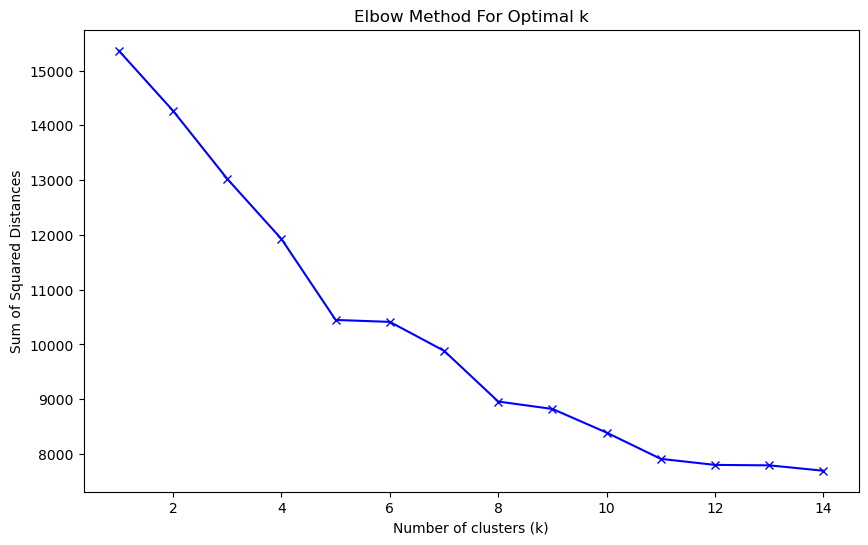

In [6]:
# Determinar el número óptimo de clusters usando el método del codo
sum_of_squared_distances = []
K = range(1, 15)  # Ajuste el rango según sea necesario
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km = km.fit(x_df)
    sum_of_squared_distances.append(km.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

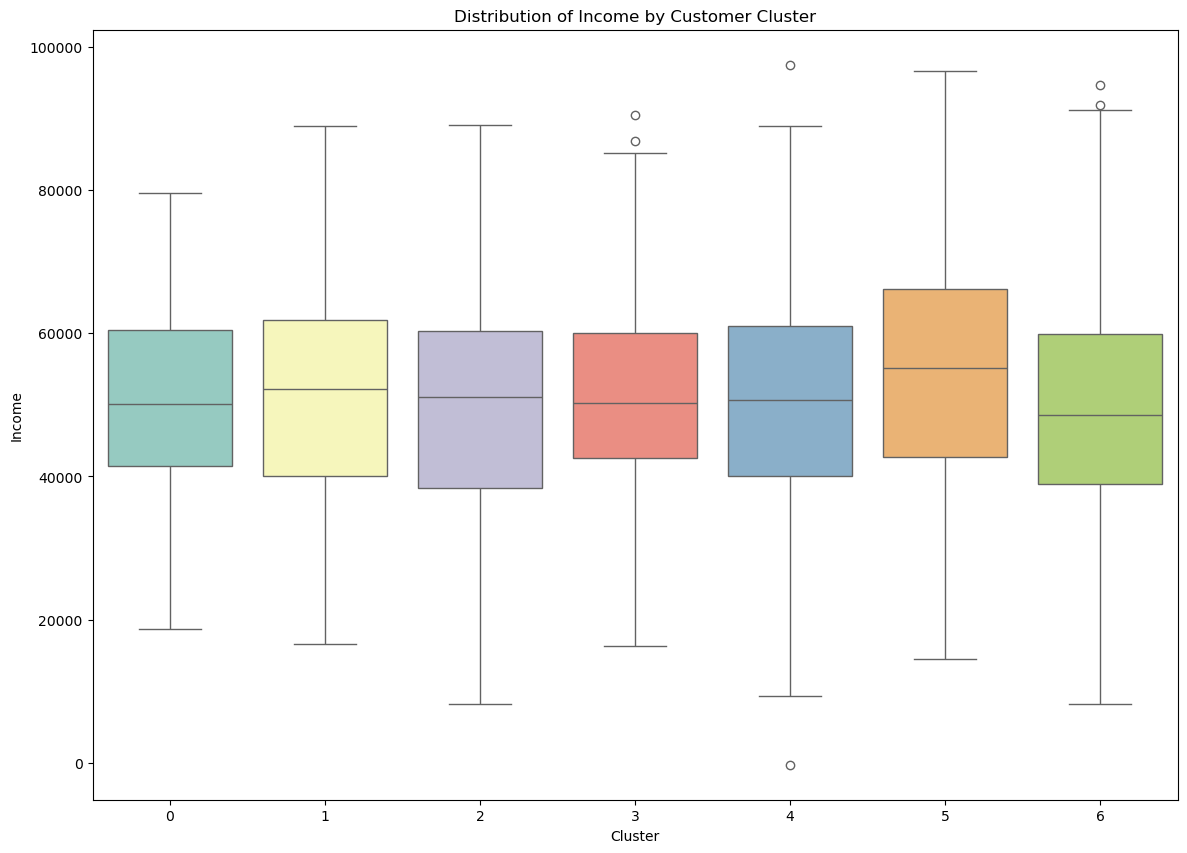

In [7]:
# Aplicar K-means clustering para identificar segmentos de clientes
kmeans = KMeans(n_clusters=7, random_state=42) 
labels = kmeans.fit_predict(x_df)

# Agregar las etiquetas del cluster al DataFrame original para análisis
data_encoded['Cluster'] = labels

# Visualizar los resultados del clustering
plt.figure(figsize=(14, 10))

# Create a boxplot to visualize the distribution of 'total_bill' for each 'Cluster'
sns.boxplot(x='Cluster', y='Income', data=data_encoded, hue='Cluster', palette='Set3', legend=False)

# Set labels and title
plt.xlabel('Cluster')
plt.ylabel('Income')
plt.title('Distribution of Income by Customer Cluster')

# Display the plot
plt.show()

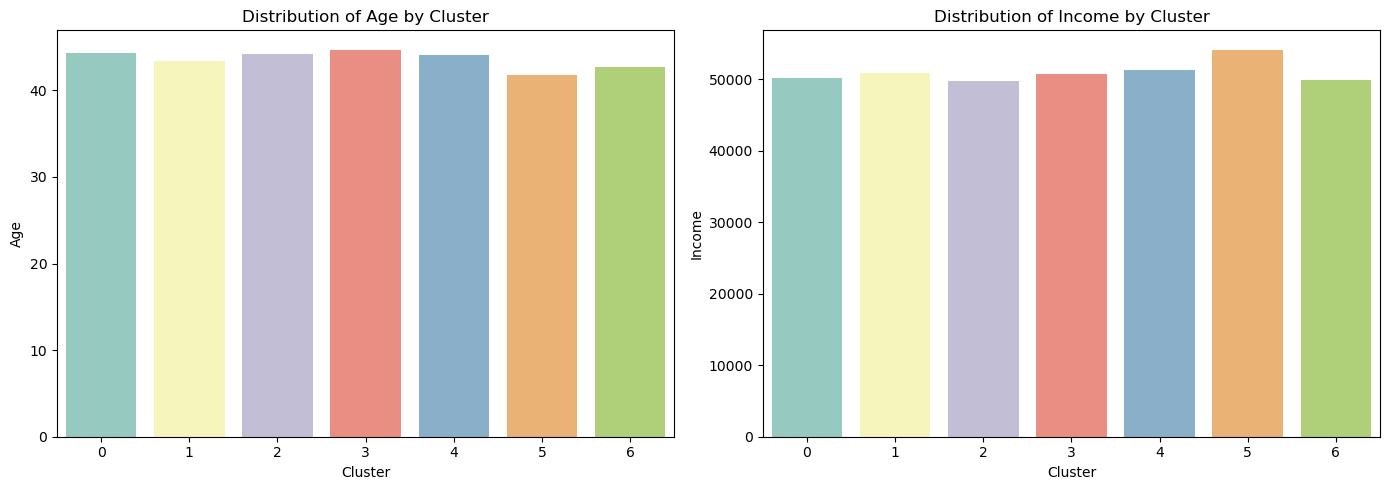

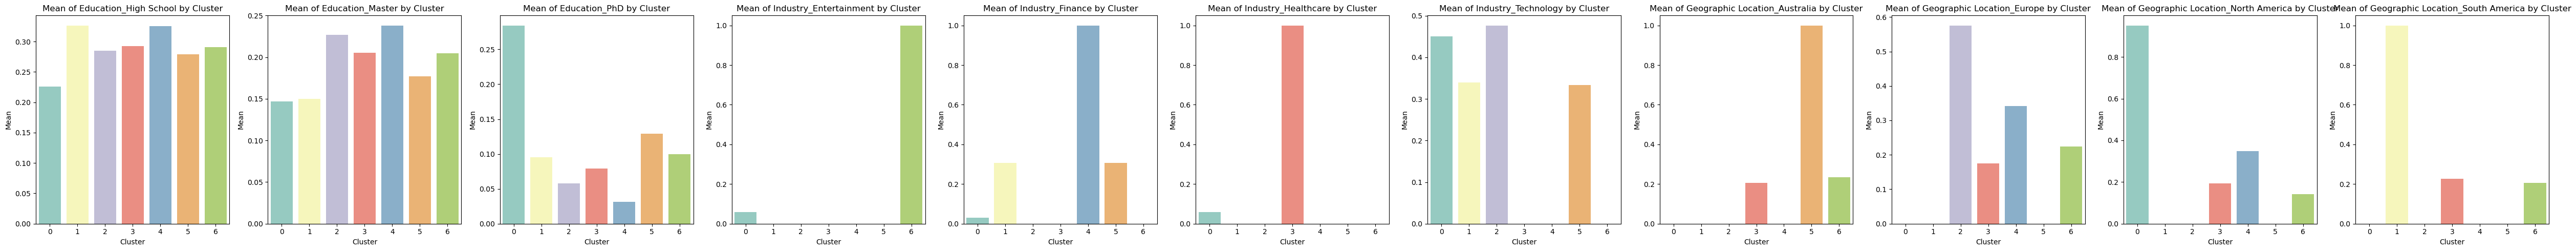

In [8]:
# Define a function to summarize the cluster characteristics
def summarize_clusters(data):
    # Numerical features
    numerical_features = ['Age','Income']  # Modify this list based on your dataset
    # Categorical features (assuming dummy variables were created)
    categorical_features = [col for col in data.columns if col.startswith('Education') or col.startswith('Industry') or col.startswith('Geographic Location')]

    # Summary DataFrame for numerical features
    cluster_summary_numerical = data.groupby('Cluster')[numerical_features].mean()
    
    # Summary DataFrame for categorical features
    cluster_summary_categorical = data.groupby('Cluster')[categorical_features].mean()

    return cluster_summary_numerical, cluster_summary_categorical

# Generate the summary for each cluster
cluster_summary_numerical, cluster_summary_categorical = summarize_clusters(data_encoded)

# Plotting
def plot_cluster_summary(cluster_summary_numerical, cluster_summary_categorical):
    # Plot numerical summaries
    fig, axes = plt.subplots(nrows=1, ncols=len(cluster_summary_numerical.columns), figsize=(14, 5))
    for i, col in enumerate(cluster_summary_numerical.columns):
        sns.barplot(x=cluster_summary_numerical.index, y=col, data=cluster_summary_numerical, ax=axes[i], hue='Cluster', palette='Set3', legend=False)
        axes[i].set_title(f'Distribution of {col} by Cluster')
        axes[i].set_xlabel('Cluster')
        axes[i].set_ylabel(col)

    plt.tight_layout()
    plt.show()

    # Plot categorical summaries
    fig, axes = plt.subplots(nrows=1, ncols=len(cluster_summary_categorical.columns), figsize=(50, 5))
    for i, col in enumerate(cluster_summary_categorical.columns):
        sns.barplot(x=cluster_summary_categorical.index, y=col, data=cluster_summary_categorical, ax=axes[i], hue='Cluster', palette='Set3', legend=False)
        axes[i].set_title(f'Mean of {col} by Cluster')
        axes[i].set_xlabel('Cluster')
        axes[i].set_ylabel('Mean')

    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_cluster_summary(cluster_summary_numerical, cluster_summary_categorical)